- 1) [x] Сгенерируйте данные

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification

In [2]:
x_data, y_data = make_classification(n_samples=1000, n_features=13,
                                     scale=1, random_state=761)

- 2) [x]  Постройте модель логистической регрессии и оцените среднюю точность

In [3]:
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.model_selection import cross_val_score

In [4]:
model = logreg(
    random_state = 555,
    solver='liblinear'
)

In [5]:
def score(x, y):
    return round(cross_val_score(model, x, y, scoring='accuracy').mean()*100, 10)

score(x_data, y_data)

94.9

- 3) [x] Используйте статистические методы для отбора признаков:

a) Выберите признаки на основе матрицы корреляции.

In [6]:
import seaborn as sns

In [7]:
df = pd.DataFrame(data=x_data)
df.insert(len(x_data[0]), 'target', y_data)

<Axes: >

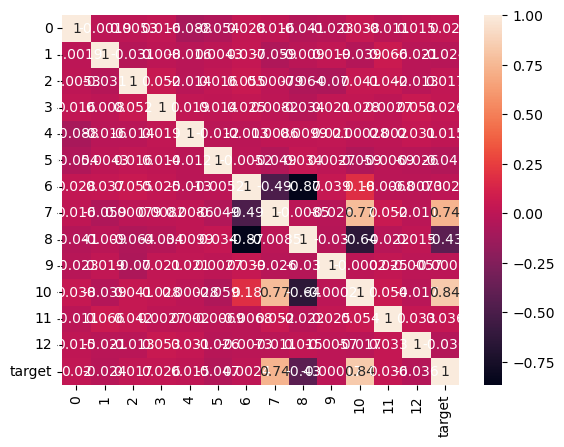

In [8]:
sns.heatmap(df.corr(), annot=True)

In [9]:
df1 = df.copy().drop([i for i in range(7) if df.corr()['target'][i] <= 0.5], axis=1)

x1 = np.array(df1.copy().drop('target', axis=1))

b) Отсеките низковариативные признаки (VarianceThreshold).

In [10]:
from sklearn.feature_selection import VarianceThreshold

In [11]:
variance = VarianceThreshold(threshold=1)

x2 = variance.fit_transform(x_data)

c) Повторите п. 2 на отобранных признаках в п. 3a, п. 3b.

In [12]:
score(x1, y_data)

95.0

In [13]:
score(x2, y_data)

95.5

- 4) [x]  Осуществите отбор признаков на основе дисперсионного анализа

a) Выберите 5 лучших признаков с помощью скоринговой функции для классификации f_classif (SelectKBest(f_classif, k=5)).

In [14]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

In [15]:
k_best = SelectKBest(f_classif, k=5)

x3 = k_best.fit_transform(x_data, y_data)

b) Повторите п. 2 на отобранных признаках.

In [16]:
score(x3, y_data)

95.4

- 5) [x] Отбор с использованием моделей

a) Реализуйте отбор признаков с помощью логистической регрессии. Отобранные признаки подайте далее на вход в саму логистическую регрессию (SelectFromModel). Используйте L1 регуляризацию.

In [17]:
from sklearn.feature_selection import SelectFromModel

In [18]:
fitted = logreg(solver='liblinear', penalty='l1', C=0.8, random_state=761)
fitted.fit(x_data, y_data)
selector = SelectFromModel(estimator=fitted)

x4 = selector.transform(x_data)

b) Реализуйте отбор признаков с помощью модели RandomForest и встроенного атрибута feature_impotance

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
forest = RandomForestClassifier(random_state=666)
forest.fit(x_data, y_data)

RandomForestClassifier(random_state=666)

<Axes: >

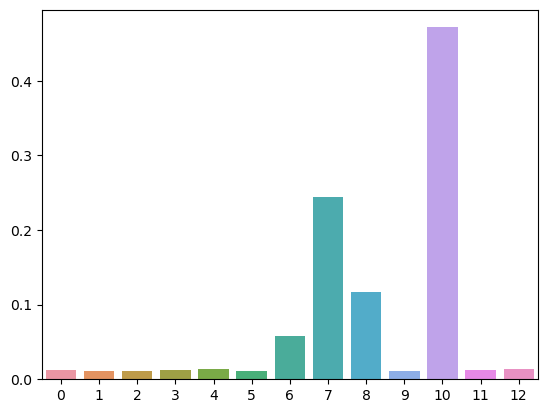

In [21]:
fi = forest.feature_importances_

sns.barplot(x=df.drop('target', axis=1).columns, y=fi)

In [22]:
selector1 = SelectFromModel(estimator=forest)

x5 = selector1.fit_transform(x_data, y_data)

c) Повторите п. 2 на отобранных признаках в п. 5a, п. 5b

In [23]:
score(x4, y_data)

95.0

In [24]:
score(x5, y_data)

95.6

- 6) [x] Перебор признаков:

a) SequentialFeatureSelector.

In [25]:
from sklearn.feature_selection import SequentialFeatureSelector as seq_feat

In [26]:
sequential = seq_feat(logreg(), n_features_to_select=5)
x6 = sequential.fit_transform(x_data, y_data)

b) Повторите п. 2 на отобранных признаках.

In [27]:
score(x6, y_data)

95.8

- 7) [x]  Сформулируйте выводы по проделанной работе:

a) Сделайте таблицу вида |способ выбора признаков|количество признаков|средняя точность модели|.

In [28]:
l = ['Original', 'Correlation', 'Variance', 'f_classif', 'L1 model', 'Random Forest', 'SequentialFS']

xs = [x_data, x1, x2, x3, x4, x5, x6]

feat_nums = map(lambda x: len(x[1]), xs)
mean_score = map(lambda x: score(x, y_data), xs)

d = {l: (n,m) for l, n, m in zip(l, feat_nums, mean_score)}

pd.DataFrame(d, index=['N features', 'Mean accuracy'])

,Original,Correlation,Variance,f_classif,L1 model,Random Forest,SequentialFS
N features,13.0,6.0,7.0,5.0,10.0,3.0,5.0
Mean accuracy,94.9,95.0,95.5,95.4,95.0,95.6,95.8


<h2><center>Выводы</center></h2>

- В результате работы был произведён отбор признаков
- Были использованы методы одномерного отбора, обёртки и методы ML-алгоритмов
- Жестче всего порезала кол-во признаков модель отбора признаков, основанная на алгоритме Random Forest
- Лучшая метрика показала результат на 0.9% лучше необработанной модели
- Все метрики отбора показали результат лучше оригинальной модели, однако эксперименты показывают, что может случаться и обратная история